In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from sklearn.datasets import make_blobs
from modAL.models import ActiveLearner
import pandas as pd
import utilities as utils

In [2]:
# Inputs from CFD - Initial data

rho = 998 # np.array([1.225, 1.225, 1.225, 1.225]) # [kg m^-3]
muo = 9.737e-4 # np.array([1.7894e-5, 1.7894e-5, 1.7894e-5, 1.7894e-5]) # [Pa s]
data = pd.read_csv('examples/outputs_initial.txt', delimiter='\t')

X_initial = np.stack((data['Pipe D'], data['Elbow angle'], data['Inlet V']), axis=-1)
y_initial = np.array(data['Del P/L'].astype('float')).reshape(-1, 1)

data

,Pipe D,Elbow angle,Mesh size,Mesh max size,Density,Viscosity,Inlet V,Inlet P,Pipe L/D,Pipe R,Pipe L,p0,p1,Del P/L
0,0.0100,1.0,0.000500,0.000500,998.0,0.000974,0.200,101325.0,10.0,0.00500,0.100,101325.01,101318.57,64.407848
1,0.0325,120.0,0.001625,0.001625,998.0,0.000974,0.050,101325.0,10.0,0.01625,0.325,101325.00,101323.55,4.460063
2,0.0550,60.0,0.002750,0.002750,998.0,0.000974,0.025,101325.0,10.0,0.02750,0.550,101325.00,101324.62,0.696204
3,0.0775,90.0,0.003875,0.003875,998.0,0.000974,0.020,101325.0,10.0,0.03875,0.775,101325.00,101324.76,0.313084
4,0.1000,30.0,0.005000,0.005000,998.0,0.000974,0.010,101325.0,10.0,0.05000,1.000,101325.00,101324.95,0.047990


In [3]:
# query strategy for regression
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

# defining the kernel for the Gaussian process
# kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# initializing the active learner
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(),
    query_strategy=GP_regression_std,
    X_training=X_initial, y_training=y_initial
)

In [28]:
# come up with distributions
D_dist = np.random.choice(np.linspace(0.005, 0.1, 1000), size = 1000)
angle_dist = np.random.choice(np.arange(1, 180), size = 1000)
vin_dist = np.random.choice(np.linspace(0.01, 1, 1000), size = 1000)

In [26]:
x = np.stack((D_dist, angle_dist, vin_dist), axis=-1)

<IPython.core.display.Javascript object>


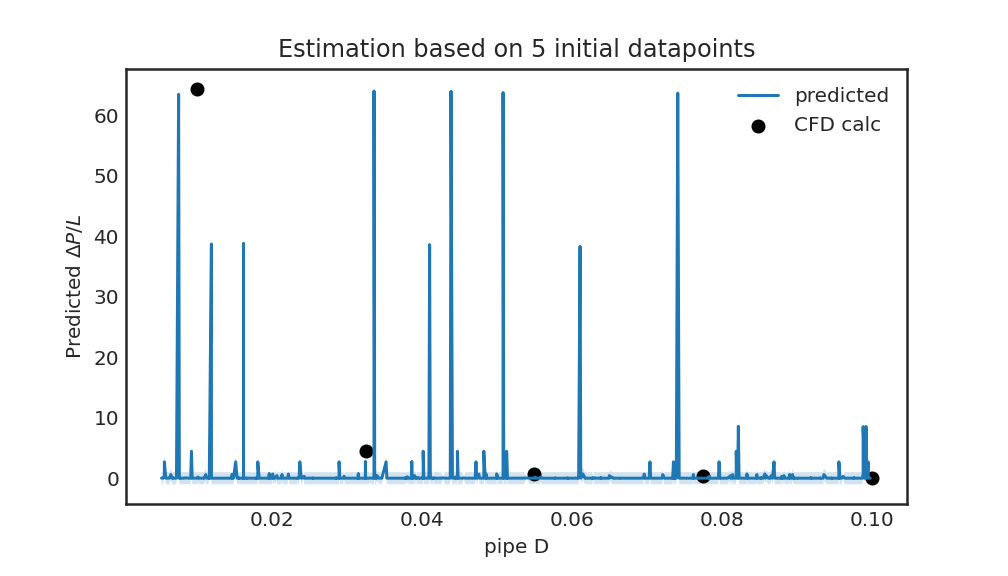

In [27]:
init_pred, init_std = regressor.predict(x, return_std=True)
init_plot = np.array([[*i, *j, k] for i,j,k in zip(x, init_pred, init_std)])
init_plot = init_plot[init_plot[:,0].argsort()]

%matplotlib notebook
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 4))
    plt.plot(init_plot[:, 0], init_plot[:,3], label='predicted')
    plt.fill_between(init_plot[:, 0], init_plot[:,3]-init_plot[:,4], init_plot[:,3]+init_plot[:,4], alpha=0.2)
    plt.scatter(X_initial[:,0], y_initial, c='k', label='CFD calc')
    plt.title('Estimation based on 5 initial datapoints')
#     plt.ylim(-2.5, 10)
    plt.xlabel('pipe D')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()

In [7]:
# active learning
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(x)
    new_x = x[query_idx]
    print(new_x)
    laminar = utils.check_laminar(new_x[0], new_x[2], rho=rho, muo=muo)
    if laminar:
        new_y = utils.run_model(*new_x, rho=rho, muo=muo, name='pipe_flow_al_{}'.format(idx))
        new_ = np.array(new_y['Del P/L'].astype(float)).reshape(-1, 1)
        X_initial = np.vstack((X_initial, new_x))
        y_initial = np.vstack((y_initial, new_))
        regressor.fit(X_initial, y_initial)
#     x = np.delete(x, query_idx)
#     pred = np.delete(pred, query_idx)

[5.22622623e-02 1.69000000e+02 7.23513514e-01]
No input was given for pipe L/D. Assuming L/D = 10.
Model inputs are saved in:
 /gpfs/fs2/scratch/hgandhi/alcfd/inputs_pipe_flow_al_0.txt
Results are stored in:
 /gpfs/fs2/scratch/hgandhi/alcfd/outputs_pipe_flow_al_0.txt.
[ 0.05207207 51.          0.31324324]
No input was given for pipe L/D. Assuming L/D = 10.
Model inputs are saved in:
 /gpfs/fs2/scratch/hgandhi/alcfd/inputs_pipe_flow_al_1.txt
Results are stored in:
 /gpfs/fs2/scratch/hgandhi/alcfd/outputs_pipe_flow_al_1.txt.
[2.62062062e-02 1.38000000e+02 4.69819820e-01]
No input was given for pipe L/D. Assuming L/D = 10.
Model inputs are saved in:
 /gpfs/fs2/scratch/hgandhi/alcfd/inputs_pipe_flow_al_2.txt
Results are stored in:
 /gpfs/fs2/scratch/hgandhi/alcfd/outputs_pipe_flow_al_2.txt.
[0.07746246 8.         0.73045045]
No input was given for pipe L/D. Assuming L/D = 10.
Model inputs are saved in:
 /gpfs/fs2/scratch/hgandhi/alcfd/inputs_pipe_flow_al_3.txt
Results are stored in:
 /gpfs

In [8]:
# sort x and pred based on bend_angle
pred, std = regressor.predict(x, return_std=True)
plot_data = np.array([[*i, *j, k] for i,j,k in zip(x, pred, std)])
plot_data = plot_data[plot_data[:,1].argsort()]
print(plot_data)

[[ 6.53853854e-02  1.00000000e+00  5.85585586e-02  6.36690694e+01
   1.51026723e-01]
 [ 9.76226226e-02  2.00000000e+00  5.25315315e-01  3.69099661e+01
   8.19509020e-01]
 [ 2.36386386e-02  3.00000000e+00  4.50000000e-01  8.44766955e+00
   9.91361311e-01]
 [ 8.18368368e-02  4.00000000e+00  2.76576577e-01  7.10235187e-01
   9.99938924e-01]
 [ 3.21971972e-02  4.00000000e+00  5.18378378e-01  6.78530170e-01
   9.99944215e-01]
 [ 1.72672673e-02  5.00000000e+00  6.74774775e-02 -1.79424946e-02
   9.99960329e-01]
 [ 5.39739740e-02  8.00000000e+00  2.11171171e-01 -3.86305366e+00
   4.86595531e-01]
 [ 7.74624625e-02  8.00000000e+00  7.30450450e-01 -4.42185510e+00
   1.00000004e-05]
 [ 5.52102102e-02  9.00000000e+00  6.18468468e-01 -2.66456749e+00
   7.98050622e-01]
 [ 9.46746747e-02  1.20000000e+01  1.19009009e-01 -1.23027306e-03
   9.99999961e-01]
 [ 1.17517518e-02  1.30000000e+01  1.99279279e-01 -1.42797081e-05
   1.00000000e+00]
 [ 1.74574575e-02  1.70000000e+01  4.98558559e-01 -1.10718269e-17

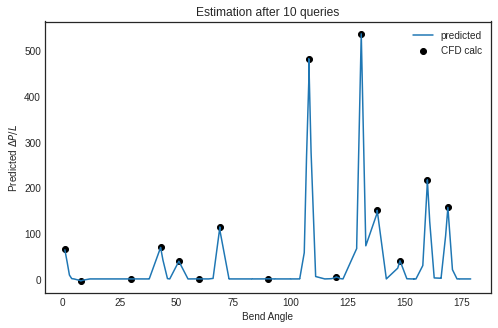

In [9]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 5))
    plt.plot(plot_data[:, 1], plot_data[:,3], label='predicted')
    plt.fill_between(plot_data[:, 1], plot_data[:,3]-plot_data[:,4], plot_data[:,3]+plot_data[:,4], alpha=0.2)
    plt.scatter(X_initial[:,1], y_initial, c='k', label='CFD calc')
    plt.title('Estimation after %d queries' % n_queries)
#     plt.ylim(-10, 500)
    plt.xlabel('Bend Angle')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()